## 11-9. 프로젝트 : 주식 예측에 도전해 보자
ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세입니다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.

https://finance.yahoo.com/

- Yahoo Finance에서 오늘 사용할 데이터셋을 다운로드할 수 있습니다.


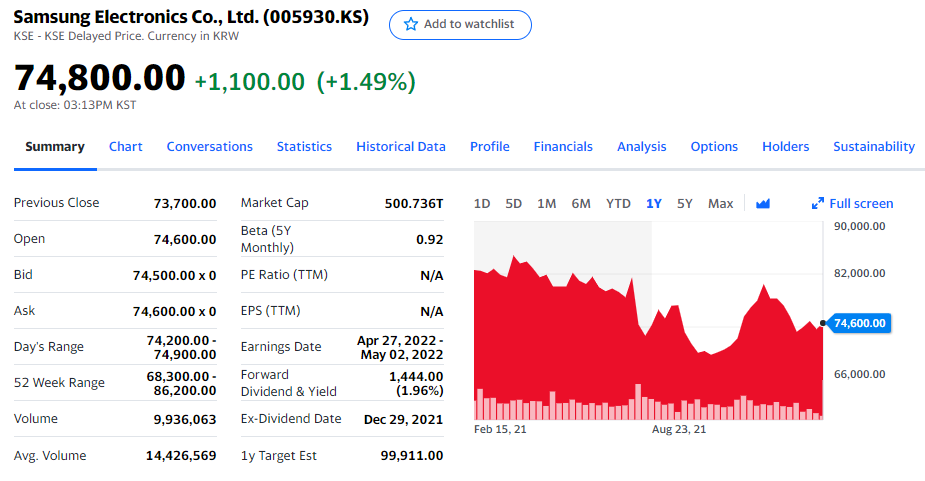

2022년 2월 16일의 차트 지표이다.

# STEP 1 : 시계열 데이터 준비
칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume<br>

- 종가(Close)만 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
#parse_dates는 날짜를 datetime 형태로 변환할지 여부, True는 해당 컬럼에 있는 데이터는 날짜 형태가 된다.

ts.head()

Date
2021-02-16    84900.0
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
결측치 처리
로그 변환

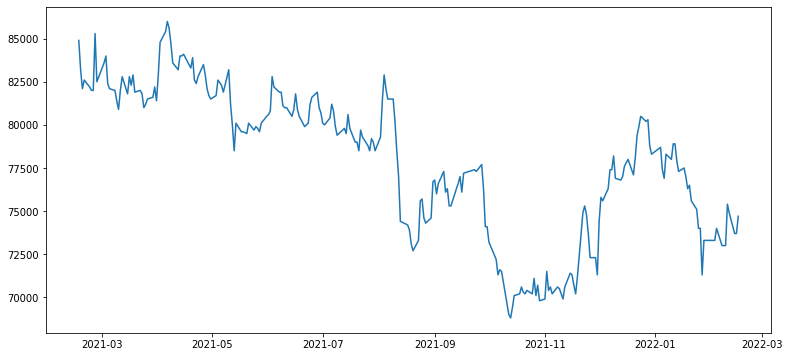

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [4]:
#결측치 처리
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

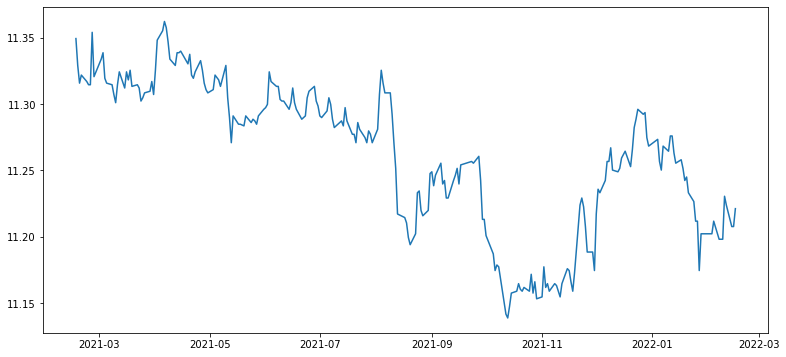

In [5]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

로그변환

# STEP 3 : 시계열 안정성 분석
정성적 그래프 분석
정량적 Augmented Dicky-Fuller Test
시계열 분해(Time Series Decomposition)
Residual 안정성 확인

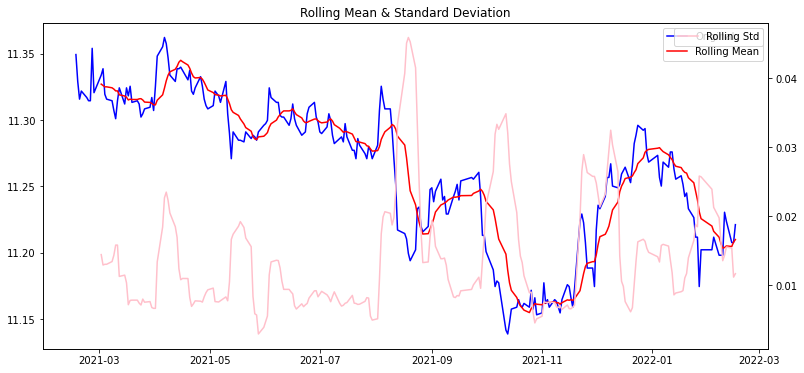

In [6]:
# 정성적 그래프 분석
def plot_rolling_statistics(ts_log, window=10):

    #pandas.Series.rolling : 동일한 사이즈만큼 옆으로 이동하면서 연산
    rolmean = ts_log.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = ts_log.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    ax1=plt.subplot(111)
    ax2=ax1.twinx()
    orig = ax1.plot(ts_log, color='blue',label='Original')    
    mean = ax1.plot(rolmean, color='red', label='Rolling Mean')
    std = ax2.plot(rolstd, color='pink', label='Rolling Std')
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#plot_rolling_statistics(ts, window=12)  
plot_rolling_statistics(ts_log, window=10)

주가가 꽤나 큰 폭으로 오르락 내리락 함<br>
std를보면 2021년 8월을 기점으로 크게 요동치고 있는 것이 보인다.
이 데이터는 안정적인 양상을 띄지 않는다고 볼 수 있다.
우리는 시계열 데이터의 안정성을 시각화 하는 방법을 통해 정성적으로 분석해 보았다.

시계열 데이터의 안정성을 평가하는 데에는 보다 정량적인 방법이 있다. 다음을 살펴볼것

### Augmented Dickey-Fuller Test
이번 스텝에서는 Augmented Dickey-Fuller Test(ADF Test) 라는 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법을 소개하려고 합니다.

이 테스트는

주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다

In [7]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(ts_log):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(ts_log, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.016782
p-value                          0.279264
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- p-value가 0.27 수준
- p-value가 0에 0.05에 가까우면 귀무가설을 기각한다

. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있겠습니다.

그러나 지금까지의 접근에서 한 가지 숨겨진 문제점이 있습니다. 바로 Moving Average를 계산하는 window=12로 정확하게 지정해 주어야 한다는 점입니다.

만약 위 코드에서 window=6을 적용하면 어떤 결과가 나올까요?


따라서 이 데이터는 0에 가까우므로 이 시계열은 비교적 안정적 시계열이라는 대립가설이 채택된다

(1에 가까우면 안정적이지 않다고 볼 수 있음)

### 시계열 분해(Time series decomposition)
statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다. 이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됩니다. 이번에는 위에서 구했던 로그 변환 단계(ts_log)에서부터 출발해 봅시다.

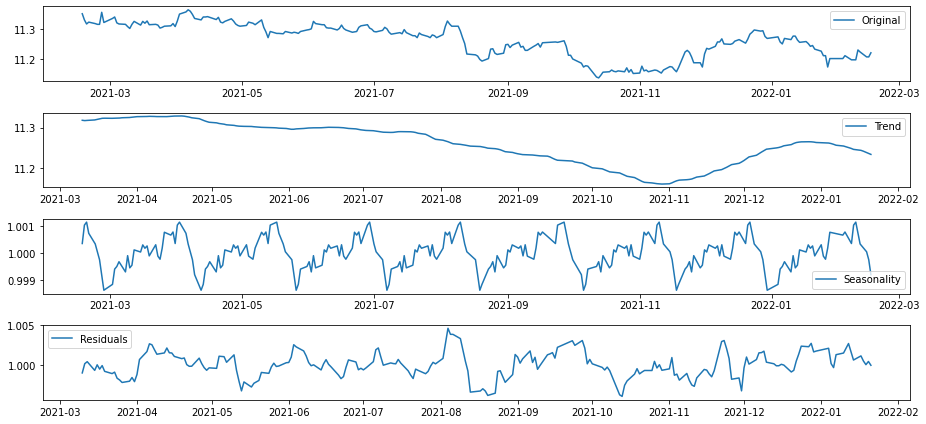

In [8]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다. 뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져 봅시다.

In [9]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.474397
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


- p-value가 0에 가까운 수로 나왔으니 안정적인 데이터로 볼 수 있다.

Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다. 어쩌면 굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까요? 물론 그렇긴 합니다만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정이었다고 이해해 주시면 좋겠습니다.

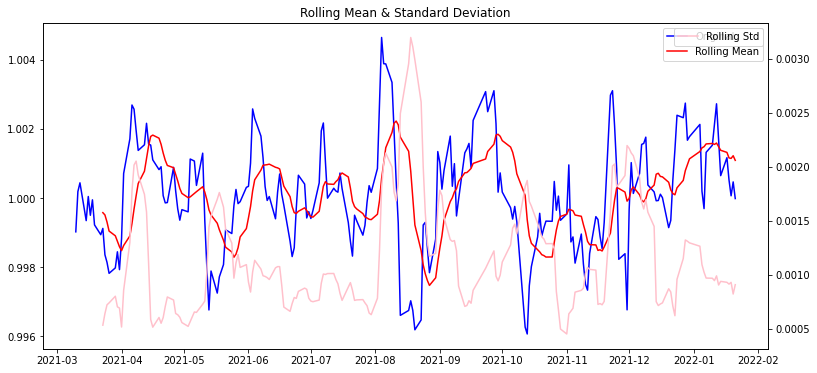

In [10]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

## STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

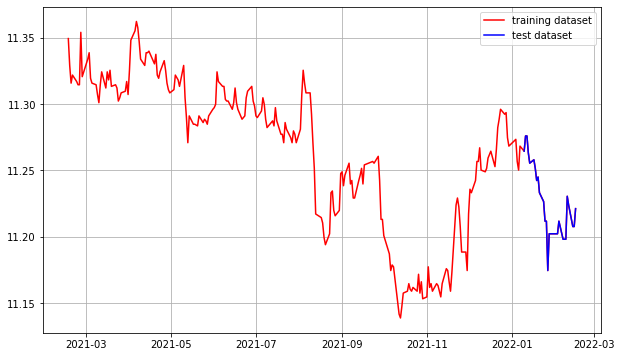

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기

차분 안정성 확인 -> d 구하기

**ARIMA(Autoregressive Integrated Moving Average)**를 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있습니다.

ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average) 라고 할 수 있는데, 각각의 개념을 살펴보면 지금까지 배운 개념과 닮아 있음을 알게 됩니다.

ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 합니다. 핵심적인 숫자들을 잘 정해야 올바른 예측식을 구할 수 있다는 것이지요.

ARIMA의 모수는 아래의 3가지가 있습니다

- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

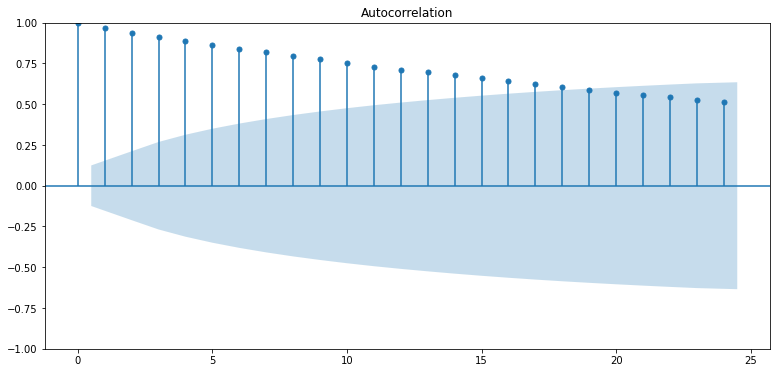

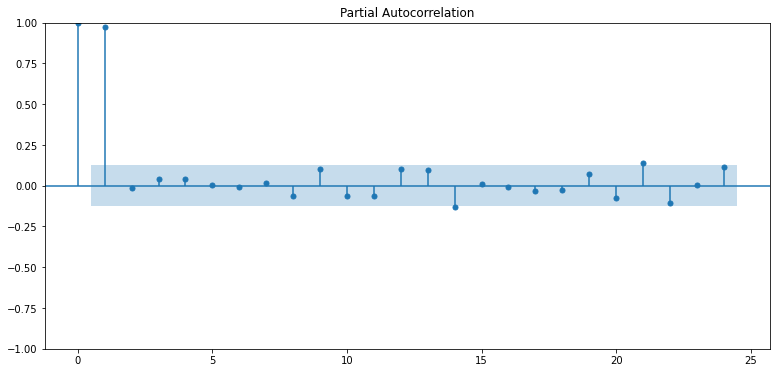

In [12]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) # ACF : Autocorrelation 그래프 그리기 
plot_pacf(ts_log) # PACF : Partial Autocorrelation 그래프 그리기 
plt.show()
# [[YOUR CODE]]

천천히 감소->안정적이지 않다


Results of Dickey-Fuller Test:
Test Statistic                -1.528067e+01
p-value                        4.582551e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


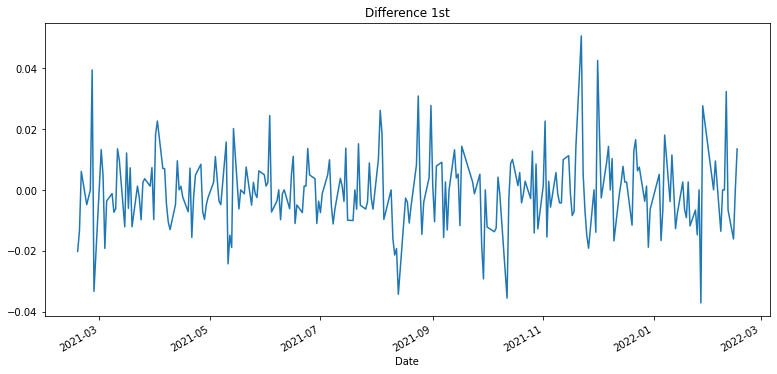

In [13]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

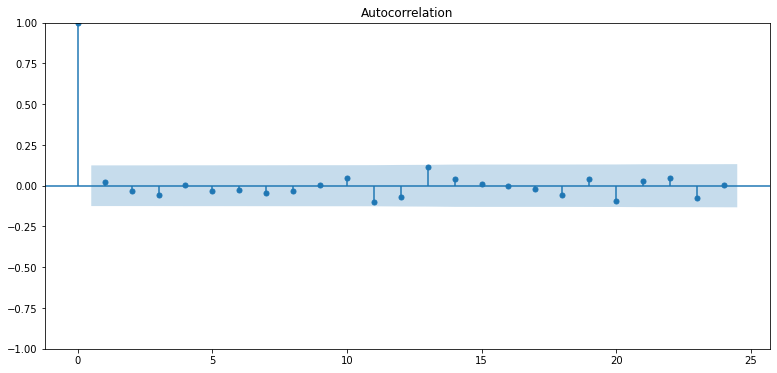

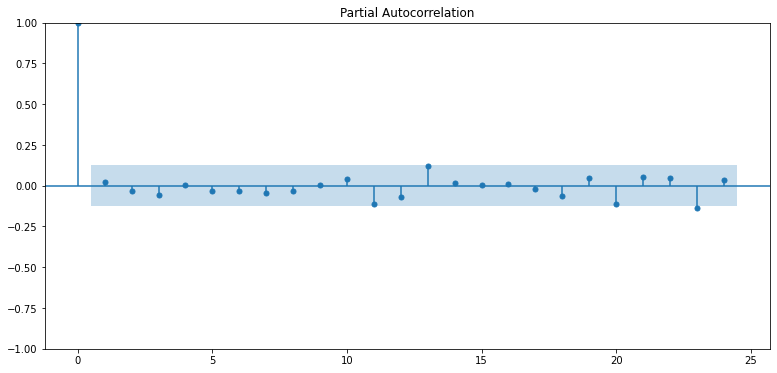

In [14]:
plot_acf(diff_1) # ACF : Autocorrelation 그래프 그리기 
plot_pacf(diff_1) # PACF : Partial Autocorrelation 그래프 그리기 
plt.show()

1을 넘어 0으로 수렴한다.<br>
p=1
d=1

# STEP 6 : ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련<br>
모델 테스트 및 플로팅<br>
최종 예측 모델 정확도 측정(MAPE)


In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 665.941
Date:                Thu, 17 Feb 2022   AIC                          -1325.882
Time:                        09:26:29   BIC                          -1315.674
Sample:                             0   HQIC                         -1321.761
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2026      1.191     -0.170      0.865      -2.537       2.131
ma.L1          0.2650      1.176      0.225      0.822      -2.040       2.570
sigma2         0.0001   9.63e-06     15.070      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


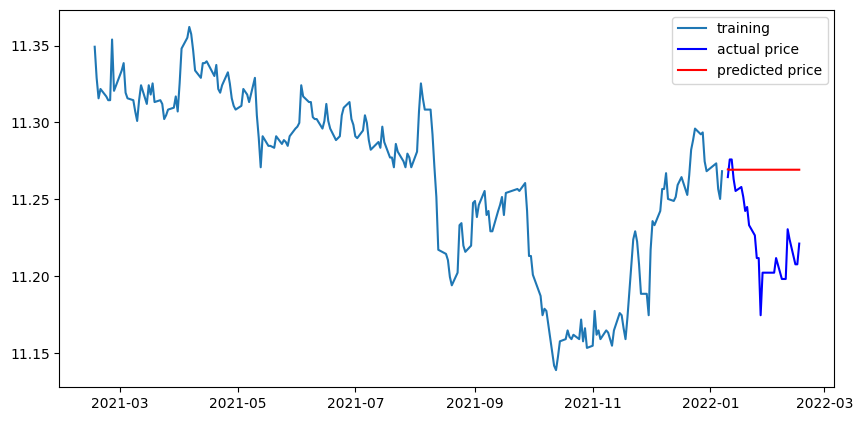

In [16]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14193471.167196995
MAE:  3247.927300712694
RMSE:  3767.4223505199143
MAPE: 4.39%


# STEP 7 : 다른 주식 종목 예측해 보기
관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기


# 디즈니

In [18]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/DIS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
#parse_dates는 날짜를 datetime 형태로 변환할지 여부, True는 해당 컬럼에 있는 데이터는 날짜 형태가 된다.

ts.head()

Date
2019-02-19    113.510002
2019-02-20    113.680000
2019-02-21    114.290001
2019-02-22    115.250000
2019-02-25    113.589996
Name: Close, dtype: float64

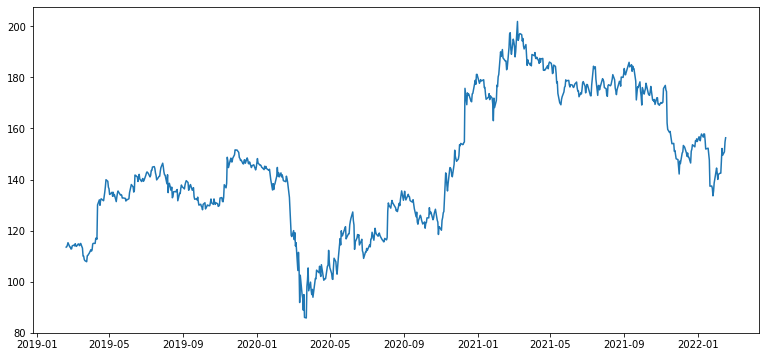

In [19]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [20]:
#결측치 처리
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

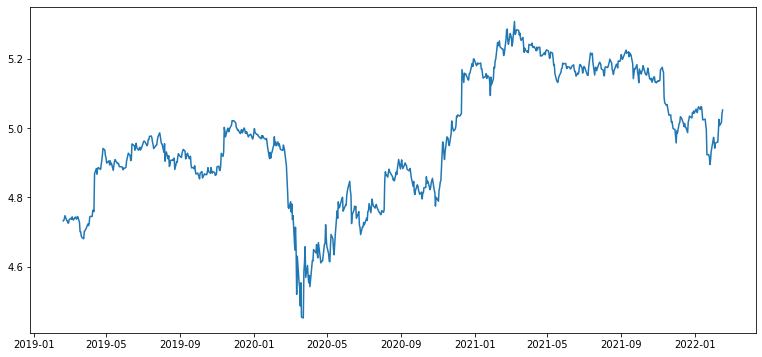

In [21]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

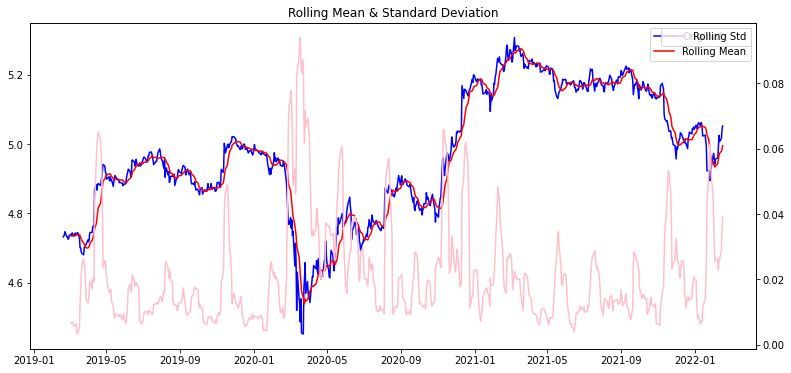

In [22]:
# 정성적 그래프 분석
def plot_rolling_statistics(ts_log, window=10):

    #pandas.Series.rolling : 동일한 사이즈만큼 옆으로 이동하면서 연산
    rolmean = ts_log.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = ts_log.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    ax1=plt.subplot(111)
    ax2=ax1.twinx()
    orig = ax1.plot(ts_log, color='blue',label='Original')    
    mean = ax1.plot(rolmean, color='red', label='Rolling Mean')
    std = ax2.plot(rolstd, color='pink', label='Rolling Std')
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#plot_rolling_statistics(ts, window=12)  
plot_rolling_statistics(ts_log, window=10)

In [23]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(ts_log):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(ts_log, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.774002
p-value                          0.393443
#Lags Used                       8.000000
Number of Observations Used    748.000000
Critical Value (1%)             -3.439123
Critical Value (5%)             -2.865412
Critical Value (10%)            -2.568832
dtype: float64


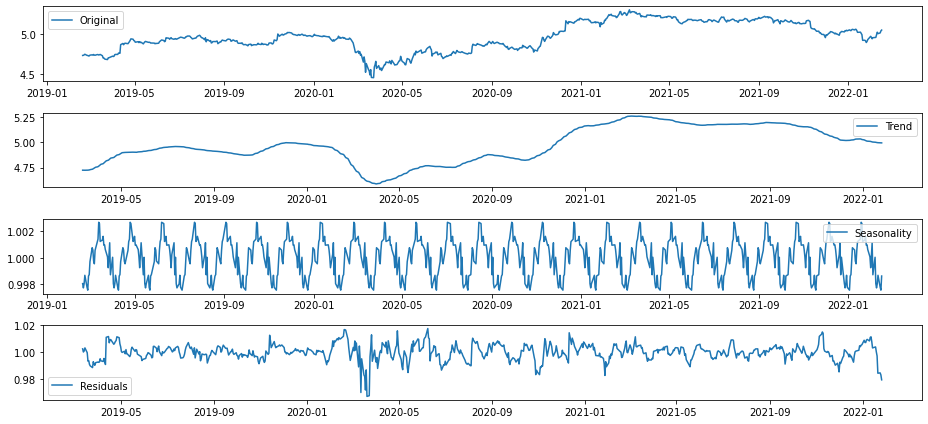

In [24]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [25]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.429482e+00
p-value                        1.887106e-13
#Lags Used                     1.200000e+01
Number of Observations Used    7.140000e+02
Critical Value (1%)           -3.439542e+00
Critical Value (5%)           -2.865596e+00
Critical Value (10%)          -2.568930e+00
dtype: float64


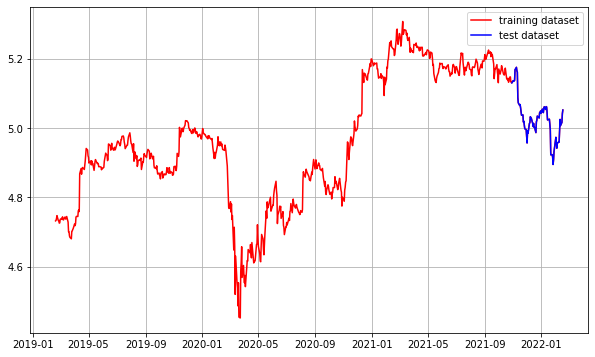

In [26]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

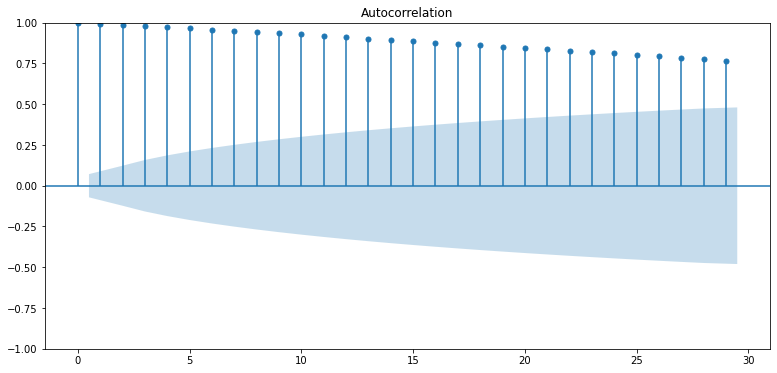

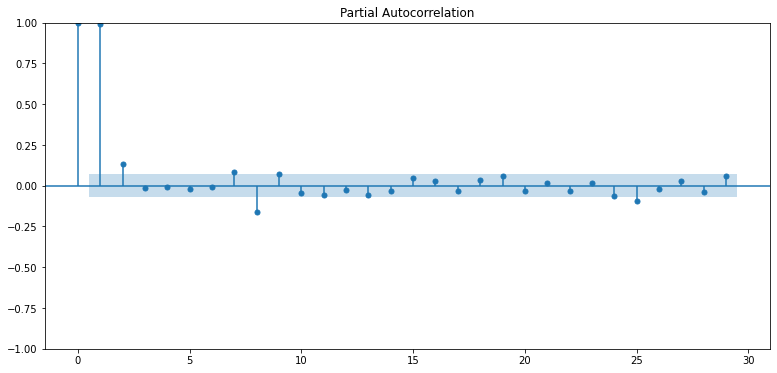

In [27]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) # ACF : Autocorrelation 그래프 그리기 
plot_pacf(ts_log) # PACF : Partial Autocorrelation 그래프 그리기 
plt.show()
# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -9.419587e+00
p-value                        5.549437e-16
#Lags Used                     7.000000e+00
Number of Observations Used    7.480000e+02
Critical Value (1%)           -3.439123e+00
Critical Value (5%)           -2.865412e+00
Critical Value (10%)          -2.568832e+00
dtype: float64


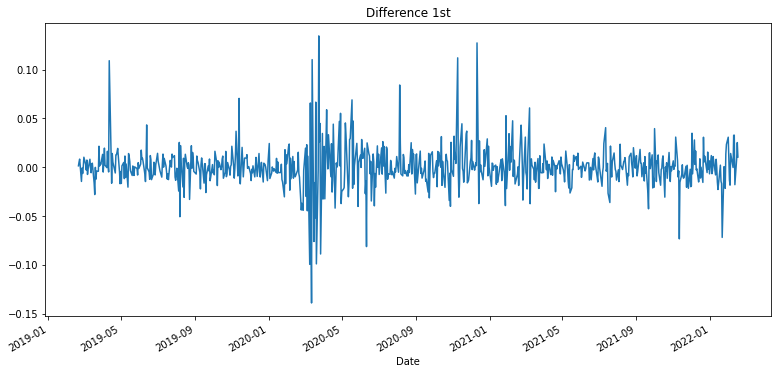

In [28]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

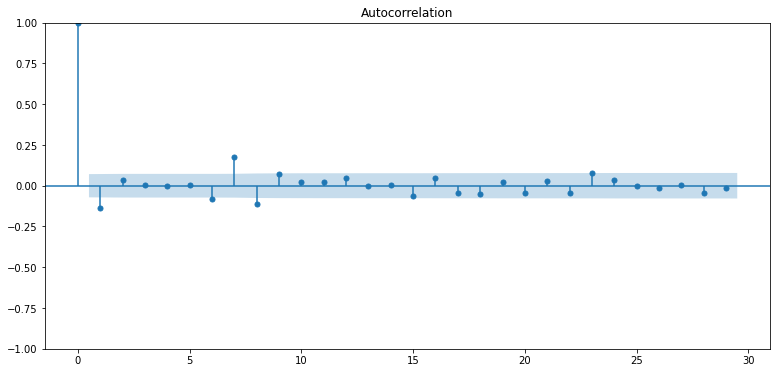

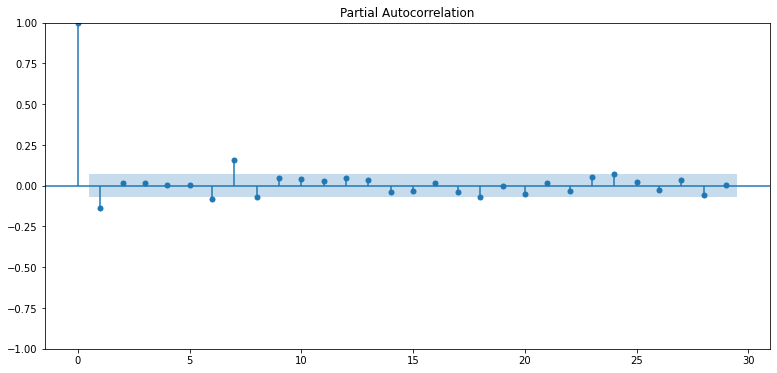

In [29]:
plot_acf(diff_1) # ACF : Autocorrelation 그래프 그리기 
plot_pacf(diff_1) # PACF : Partial Autocorrelation 그래프 그리기 
plt.show()

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  681
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1637.505
Date:                Thu, 17 Feb 2022   AIC                          -3267.011
Time:                        09:26:53   BIC                          -3248.916
Sample:                             0   HQIC                         -3260.007
                                - 681                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9600      0.114     43.617      0.000       4.737       5.183
ar.L1          0.9948      0.003    312.840      0.000       0.989       1.001
ma.L1         -0.1542      0.022     -7.036      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


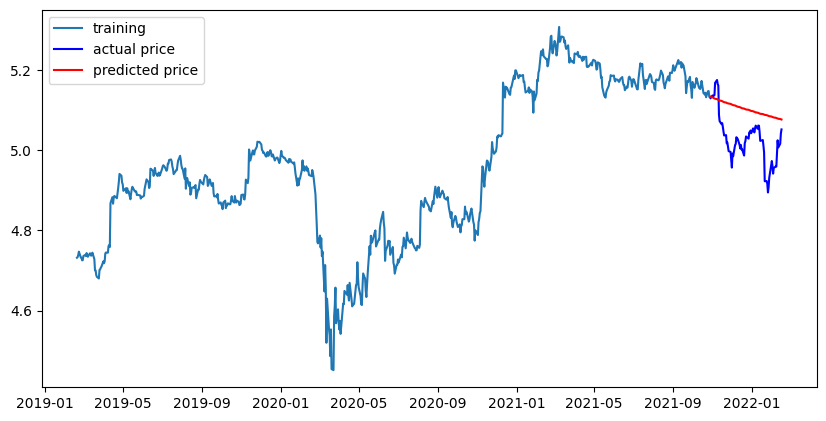

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  201.27274545076318
MAE:  12.58363673270223
RMSE:  14.187062608262613
MAPE: 8.50%


# 코카콜라

In [33]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/KO.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
#parse_dates는 날짜를 datetime 형태로 변환할지 여부, True는 해당 컬럼에 있는 데이터는 날짜 형태가 된다.

ts.head()

Date
2017-02-17    41.230000
2017-02-21    41.459999
2017-02-22    41.599998
2017-02-23    41.660000
2017-02-24    41.779999
Name: Close, dtype: float64

In [34]:
#결측치 처리
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

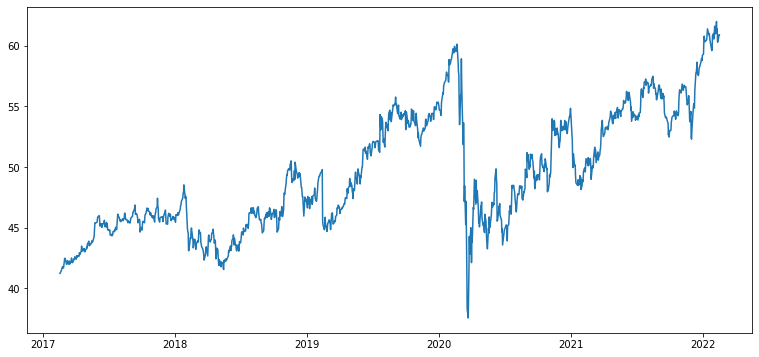

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

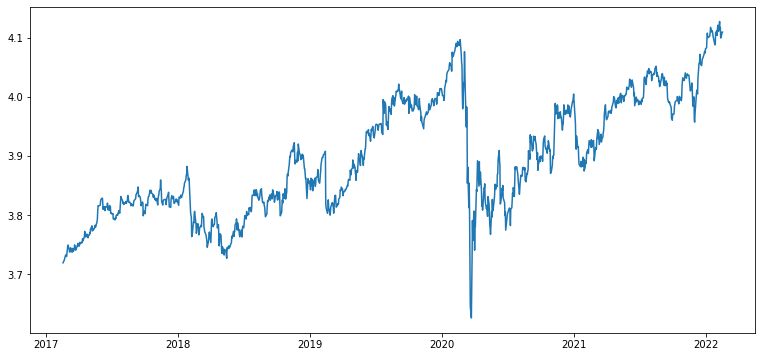

In [36]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

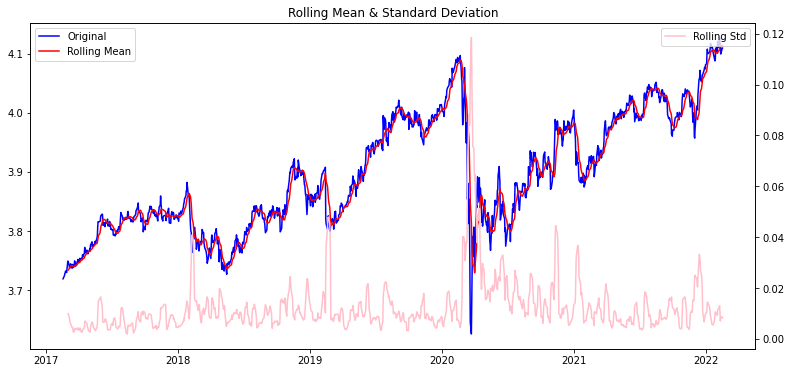

In [37]:
# 정성적 그래프 분석
def plot_rolling_statistics(ts_log, window=10):

    #pandas.Series.rolling : 동일한 사이즈만큼 옆으로 이동하면서 연산
    rolmean = ts_log.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = ts_log.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    ax1=plt.subplot(111)
    ax2=ax1.twinx()
    orig = ax1.plot(ts_log, color='blue',label='Original')    
    mean = ax1.plot(rolmean, color='red', label='Rolling Mean')
    std = ax2.plot(rolstd, color='pink', label='Rolling Std')
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#plot_rolling_statistics(ts, window=12)  
plot_rolling_statistics(ts_log, window=10)

In [38]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(ts_log):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(ts_log, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.892050
p-value                           0.335810
#Lags Used                       12.000000
Number of Observations Used    1246.000000
Critical Value (1%)              -3.435609
Critical Value (5%)              -2.863862
Critical Value (10%)             -2.568006
dtype: float64


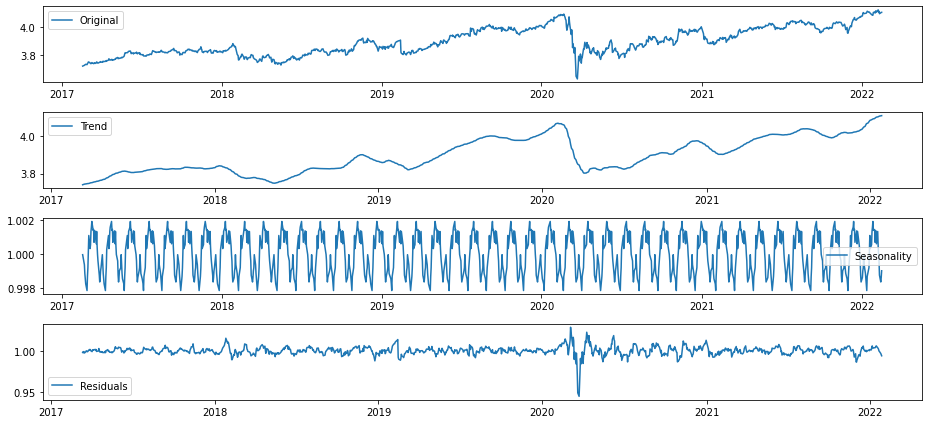

In [39]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [40]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.094994e+01
p-value                        8.849722e-20
#Lags Used                     2.100000e+01
Number of Observations Used    1.207000e+03
Critical Value (1%)           -3.435779e+00
Critical Value (5%)           -2.863938e+00
Critical Value (10%)          -2.568046e+00
dtype: float64


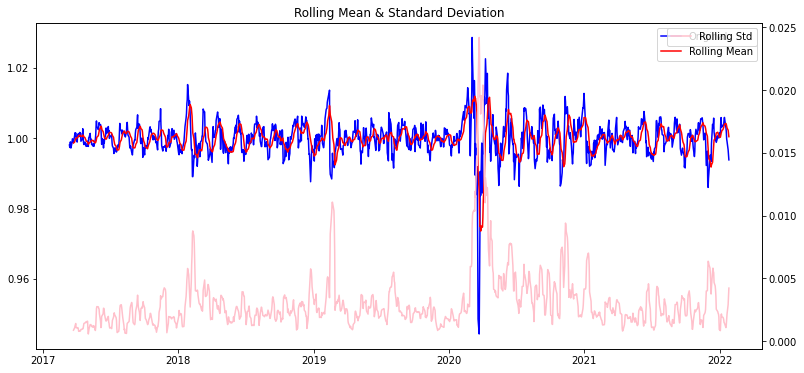

In [41]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

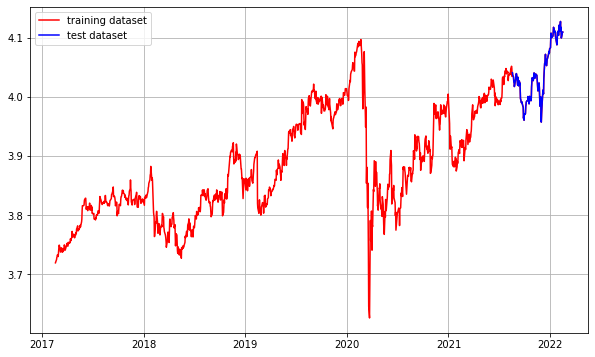

In [42]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

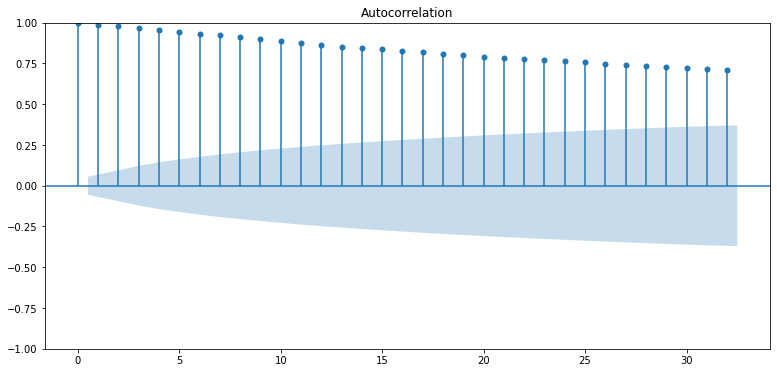

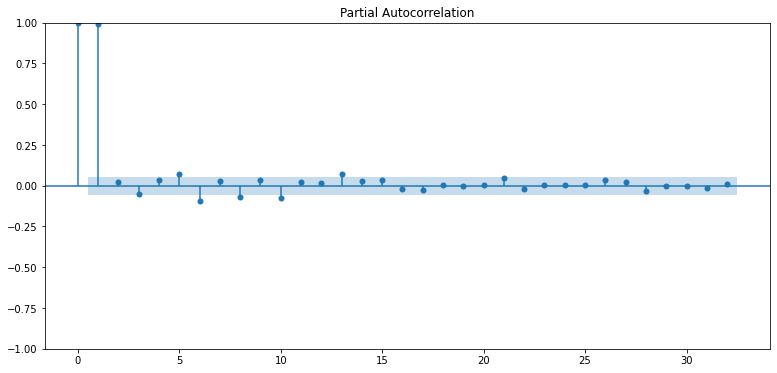

In [43]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) # ACF : Autocorrelation 그래프 그리기 
plot_pacf(ts_log) # PACF : Partial Autocorrelation 그래프 그리기 
plt.show()
# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -1.119984e+01
p-value                        2.258229e-20
#Lags Used                     1.100000e+01
Number of Observations Used    1.246000e+03
Critical Value (1%)           -3.435609e+00
Critical Value (5%)           -2.863862e+00
Critical Value (10%)          -2.568006e+00
dtype: float64


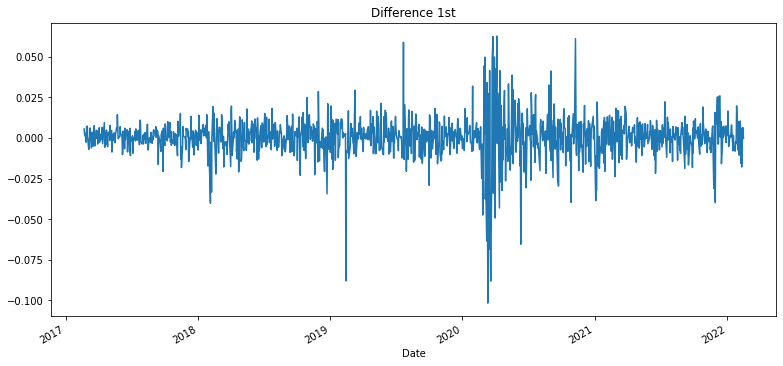

In [44]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

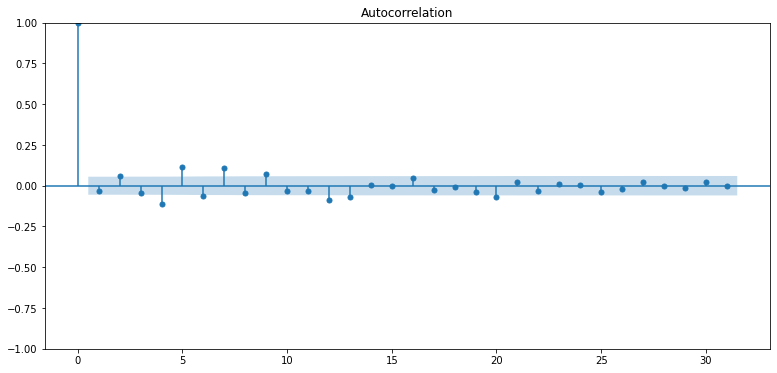

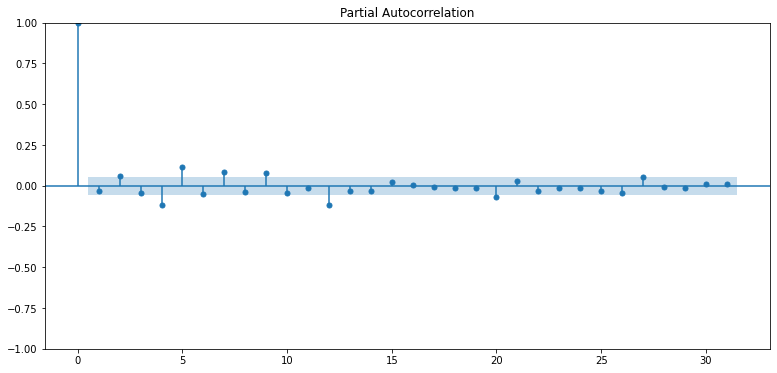

In [45]:
plot_acf(diff_1) # ACF : Autocorrelation 그래프 그리기 
plot_pacf(diff_1) # PACF : Partial Autocorrelation 그래프 그리기 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.243313e+01
p-value                        3.900114e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.234000e+03
Critical Value (1%)           -3.435660e+00
Critical Value (5%)           -2.863885e+00
Critical Value (10%)          -2.568019e+00
dtype: float64


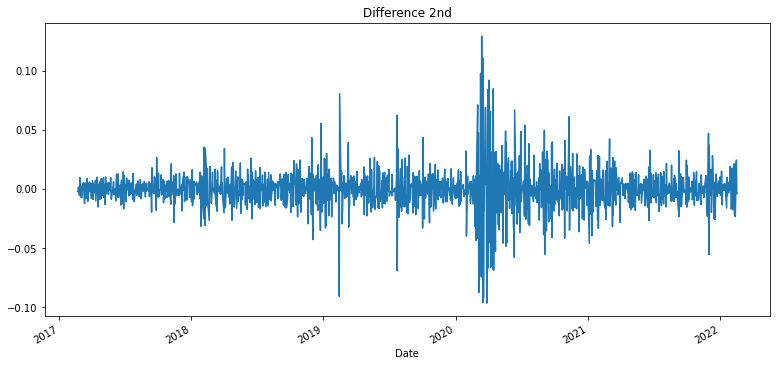

In [47]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

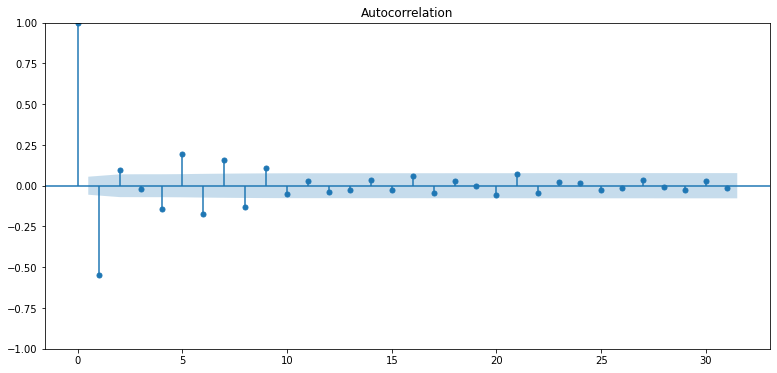

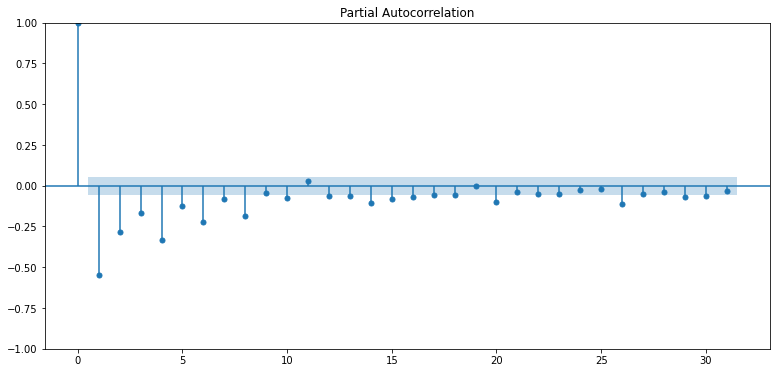

In [48]:
plot_acf(diff_2) # ACF : Autocorrelation 그래프 그리기 
plot_pacf(diff_2) # PACF : Partial Autocorrelation 그래프 그리기 
plt.show()

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(2, 1, 2)   Log Likelihood                3309.331
Date:                Thu, 17 Feb 2022   AIC                          -6608.662
Time:                        09:28:22   BIC                          -6583.504
Sample:                             0   HQIC                         -6599.158
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7234      0.061    -11.892      0.000      -0.843      -0.604
ar.L2         -0.6231      0.055    -11.420      0.000      -0.730      -0.516
ma.L1          0.6952      0.058     12.015      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


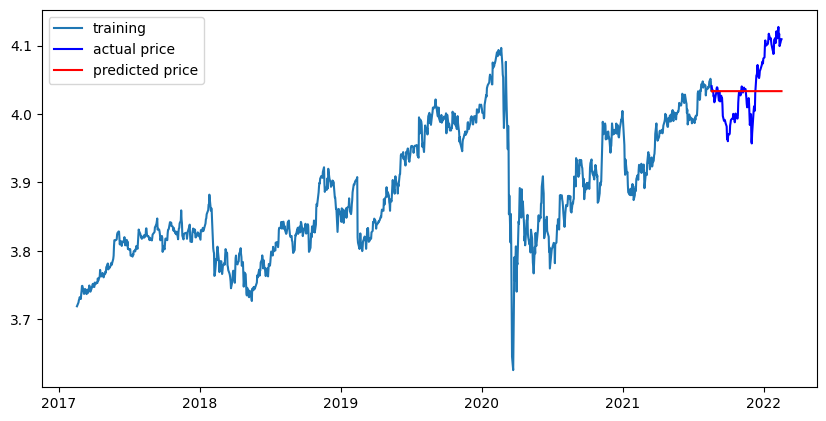

In [53]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  37.03480142336909
MAE:  4.647483728414648
RMSE:  6.085622517324673
MAPE: 7.90%


# 루브릭

|평가문항||상세기준|
|:------------------------||:---------------------|
|1. 시계열의 안정성이 충분히 확인되었는가?||플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?||p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?||3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

# 회고

- 예측선을 보면 잘 나온것같지 않다.
- 주식은 여러 변동요인이 수요공급에 영향을 미치기 때문에
- 그날 가격만으로는 예측하기 힘든게 맞다.
- 이번꺼는 ARIMA를 이용해서 (pdi)를 적용시키는 과정이 새로웠다.
- 수학적 통계적인 내용이 어려워서 이해하기는 힘들었다.
- 통계지식이 중요하다고 생각했다.😂